<center><h1> eXtreme Gradient Boosting as a Multiclass Classifier on Ontario Road Quality with Random Search Hyperparameter Optimization</h1></center>

<center><h4> Nyasha M, 30 Apr 2021 </h4></center><p>&nbsp;</p>

**Background:** This notebook used eXtreme Gradient Boosting (XGBoost) on the *Pavement condition for provincial highways* dataset from the government of Canada (available here: https://open.canada.ca/data/en/dataset/01dfc06c-6ef0-4fd0-a010-8ba20e3c9d10). The dataset contains the readings from an Automatic Road Analyzer (ARAN) that was used on various sections of road in Ontario (e.g., freeway, local road, arterial). 

Each section of road pavement was automatically evaluated by the ARAN based on its distress (Distress Manifestation Index, DMI), wheel track rutting (in mm), and roughness (International Roughness Index, IRI). These indices were then combined into a Pavement Condition Index (PCI) for an overall rating of road pavement condition.

**Objective:** I wanted to determine what features might predict for good or bad quality roads in Ontario. I also wanted to see if my final model could be simplified in some by selecting only those features which contributed significantly to--or improved--the model's balanced accuracy.

**Methods:** The PCI scores from the dataset were changed into a multiclass feature, based on the category that a particular PCI score fell into (refer to the table below). I then used an XGBoost Multiclass Classifier to predict what class (i.e., road pavement quality category) different sections of roads in Ontario fell into. 

My preliminary model was followed by hyperparameter optimization via a random search, which was validated by using k-folds cross-validation, given the imbalanced frequency of road quality classes in my dataset. I used these optimized parameters to rerun another XGBoost model and compare it to my old one. I then computed the feature importance (f1-score) and balanced accuracy in a stepwise manner as I tested the incremental removal of features (from least to greatest importance) from my model. This final step was done to see if my final model could be simplified in some way without significantly sacrificing its balanced accuracy.

| Category      | PCI score |
| :---------- | :----------- |
| **Good**      | 85 - 100       |
| **Satisfactory**   | 70 - 85        |
| **Fair**      | 55 - 70       |
| **Poor**   | 40 - 55        |
| **Very poor**      | 25 - 40       |
| **Serious**   | 10 - 25        |
| **Failed**      | 0 - 10       |

Refer to the guide here for more information on the PCI and its categories: https://faapaveair.faa.gov/Help/PavementConditionIndexPCI.html.

### Package Imports

In [1]:
import warnings;
warnings.filterwarnings('ignore');

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sc

# Model preprocessing
import sklearn.preprocessing as preprocess
from sklearn.model_selection import train_test_split
import itertools

# Modeling and model metrics
import xgboost
from xgboost import XGBClassifier, plot_tree
from sklearn.compose import make_column_transformer
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, classification_report, plot_confusion_matrix, make_scorer 
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectFromModel

In [3]:
# Change plotting style.
#plt.style.use('default')
plt.style.use('bmh') 

### Data Exploration 
Note: Univariate plotting was not done on all variables.

In [4]:
df = pd.read_csv("open_data_submission_2017_pavement_final.csv")
df.head(3)

,SectionID,Highway,DIR,LHRS,Offset,FROM_Distance,TO_Distance,PCI,DMI,IRI,Pave_Type,Pavement_Section_From,Pavement_Section_To,FUNC_CLASS
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,QEW,E,10004.0,0.0,0.23,4.658,86.53,9.10,1.22,AC,FORT ERIE - GILMORE RD IC-5,FORT ERIE - CENTRAL AV IC,FWY
2,NaN,QEW,W,10004.0,0.0,0.23,4.658,84.26,8.74,1.09,AC,FORT ERIE - CENTRAL AV IC,FORT ERIE - GILMORE RD IC-5,FWY


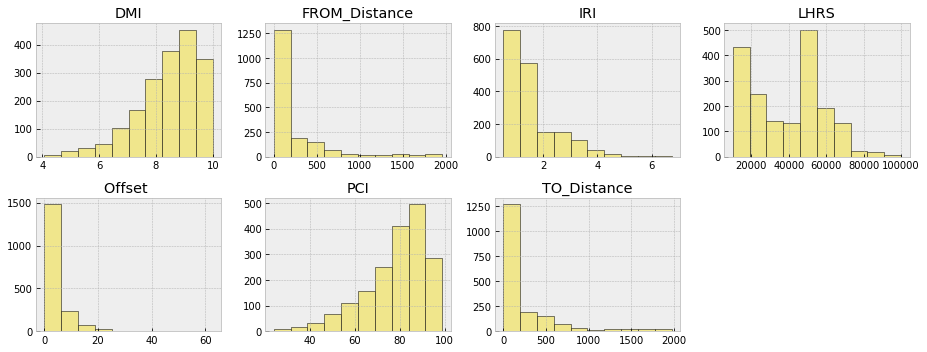

In [5]:
df.loc[:,'LHRS':'IRI'].hist(figsize=(13,5), color='khaki', edgecolor='black', layout=(2,4)), plt.tight_layout()
plt.show()

Let's check if our outcome variable of interest--PCI--might have any missing values. Let's also explore how some of the categorical data looks like.

In [6]:
df.PCI.isna().value_counts() # only one missing value under the PCI column.

False    1828
True        1
Name: PCI, dtype: int64

Now the categorical features:

In [7]:
print("Number of unique observations in Pavement_Section: ", len(df.Pavement_Section_From.unique()))
print("Number of unique observations in Highway: ", len(df['Highway '].unique()))

print(f"\nDIR, Pave_Type, and FUNC_CLASS: \n------------------------------------",
      f"\n{df.DIR.value_counts()} \n\n{df.Pave_Type.value_counts()} \n\n{df.FUNC_CLASS.value_counts()}")

Number of unique observations in Pavement_Section:  1485
Number of unique observations in Highway:  243

DIR, Pave_Type, and FUNC_CLASS: 
------------------------------------ 
B    1175
W     187
E     186
N     140
S     140
Name: DIR, dtype: int64 

AC    1422
ST     287
CO      85
PC      34
Name: Pave_Type, dtype: int64 

ART    639
FWY    626
LOC    417
COL    146
Name: FUNC_CLASS, dtype: int64


In order to run XGBoost as a classifier, we need our outcome to be continuous. We were thinking of dividing PCI into categories based on the PCI score--what might be some plausible categories/divisions? 

**Note:** I tested different cut-offs ahead of time and decided to group any PCI value that was equivalent to 'very poor' or worse together, due to the very small number of PCI scores that fell into the categories of 'failure', 'serious', or 'very poor' road conditions.

In [8]:
PCI_group_counts = [len(df.PCI[df.PCI<=40]), len(df.PCI[(df.PCI<=55) & (df.PCI>40)]), len(df.PCI[(df.PCI<=70) & (df.PCI>55)]),
                      len(df.PCI[(df.PCI<=85) & (df.PCI>70)]), len(df.PCI[(df.PCI<=100) & (df.PCI>85)])]
pd.DataFrame(data=[PCI_group_counts], columns=['< poor', 'poor', 'fair', 'satisfactory', 'good'], index=['counts:'])

,< poor,poor,fair,satisfactory,good
counts:,27,107,281,702,711


### Data preprocessing
Let's first create a variable called `road_status` to categorize the pavement quality of each road, based on its PCI score. 

We'll also remove some arbitrary features as well as features that have a massive number of unique identifiers. These would be useless/impractical to turn into value labels for our model. Finally, we'll then remove `PCI` given that its information would be stored (in the form of categories) in `road_status`.

In [9]:
df['road_status'] = np.nan
df.loc[df.PCI<=40, 'road_status'] = 'very poor'
df.loc[(df.PCI<=55) & (df.PCI>40), 'road_status'] = 'poor'
df.loc[(df.PCI<=70) & (df.PCI>55), 'road_status'] = 'fair'
df.loc[(df.PCI<=85) & (df.PCI>70), 'road_status'] = 'satisfactory'
df.loc[(df.PCI<=100) & (df.PCI>85), 'road_status'] = 'very good'

In [10]:
# 'SectionID' unlikely to be useful. 'Highway' has too many unique values for encoding (see above).
drop_col = ['SectionID', 'Pavement_Section_From', 'Pavement_Section_To', 'PCI', 'Highway ']
df = df.drop(drop_col, axis=1)

Are there any missing values in the dataset and if so, where are they? OneHotEncoding won't work with NaN, so we must remove these.

In [11]:
df[df.isna().any(axis=1)]

,DIR,LHRS,Offset,FROM_Distance,TO_Distance,DMI,IRI,Pave_Type,FUNC_CLASS,road_status
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Remove NaN row and then run OneHotEncoding.

In [12]:
df = df[df.isna().any(axis=1)==False]
df = df.reset_index(drop=True) # Reset index so it starts back at 0, for (later) proper concatentation of dataframes.

In [13]:
enc = preprocess.OneHotEncoder()
trans = enc.fit_transform(df[['DIR', 'Pave_Type', 'FUNC_CLASS']]).toarray()
trans_df = pd.DataFrame(trans, columns = enc.get_feature_names(['DIR', 'Pave_Type', 'FUNC_CLASS']))

Concatenate the old and HotEncoded-dataframes together.

In [14]:
df_merged = pd.concat([df, trans_df], axis=1)

Finally, convert our categorical outcome into numbers instead of strings, then drop the old categories.

In [15]:
le = preprocess.LabelEncoder()
df_merged[['road_status']] = df[['road_status']].apply(le.fit_transform)

df_merged = df_merged.drop(['DIR', 'Pave_Type', 'FUNC_CLASS'],axis=1)
df_merged.head(4)

,LHRS,Offset,FROM_Distance,TO_Distance,DMI,IRI,road_status,DIR_B,DIR_E,DIR_N,DIR_S,DIR_W,Pave_Type_AC,Pave_Type_CO,Pave_Type_PC,Pave_Type_ST,FUNC_CLASS_ART,FUNC_CLASS_COL,FUNC_CLASS_FWY,FUNC_CLASS_LOC
0,10004.0,0.0,0.230,4.658,9.10,1.22,3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,10004.0,0.0,0.230,4.658,8.74,1.09,2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,10014.0,0.0,4.658,13.227,7.09,1.12,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,10014.0,0.0,4.658,13.227,7.11,1.05,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Train-test Splits
Let's select the 'x' and 'y' features to put into the model. 'y' is our outcome variable--`road status`--which stores the categorized `PCI` scores.

In [16]:
# Create train and test splits of the data.
x, y = df_merged.loc[:, df_merged.columns!='road_status'], df_merged['road_status']
seed = 100
test_size = 0.20

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed)

eval_set = [(x_train, y_train), (x_test, y_test)] # Set our evaluation set.

### Running an initial XGBoost Model
Let's run an initial model to see how well the model on the default settings performs on predicting poor/fair/good road pavement quality. We'll also set an early stopping round value to prevent overfitting.

In [17]:
params = {# Defaults
    'booster':'gbtree',
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'tree_method':'exact',
    
    # Type of model, number of classes in outcome variable
    'objective':'multi:softmax', 'num_class':5,
    
    # evaluation metrics for choosing the best model 
    'eval_metric':['mlogloss', 'merror']}

In [18]:
stop_after = 40 # set number of early stopping rounds to prevent overfitting. Can adjust to test.

In [19]:
xgb_orig = XGBClassifier(n_estimators=1000, **params, use_label_encoder=False)
# Make equal to '_' to suppress output from .fit
_ = xgb_orig.fit(x_train, y_train, early_stopping_rounds=stop_after, eval_set=eval_set, eval_metric=["merror","mlogloss"], verbose=False)

Extract the model's evaluation results from XGBoost. Plot the model's multiclass log loss and misclassification error.

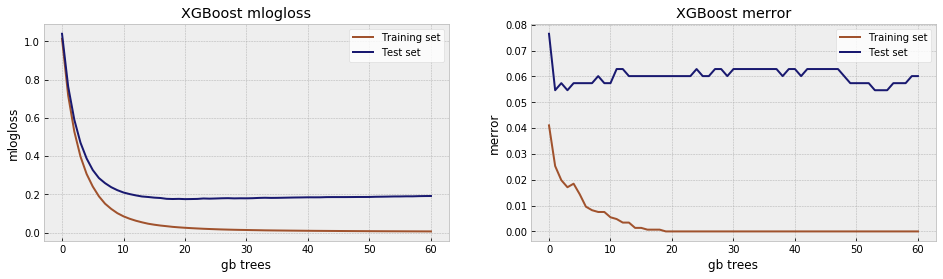

In [20]:
train_results, test_results = xgb_orig.evals_result_['validation_0'], xgb_orig.evals_result_['validation_1']
plot_eval_metrics=['mlogloss', 'merror']

plt.style.use('bmh') 
fig, axs = plt.subplots(1,2, figsize=(16,4))
for m in enumerate(plot_eval_metrics):
    axs[m[0]].plot(range(0,len(train_results[m[1]])), train_results[m[1]], color='sienna', label='Training set')
    axs[m[0]].plot(range(0,len(test_results[m[1]])), test_results[m[1]], color='midnightblue', label='Test set')

    axs[m[0]].set_title(f'XGBoost {m[1]}'), 
    axs[m[0]].set_xlabel('gb trees'), axs[m[0]].set_ylabel(m[1])
    axs[m[0]].legend(facecolor='white')
plt.show()

In [21]:
y_pred = [np.nan]*2 # Create array to store first round of XGBoost's results.
cv_accuracies = [np.nan]*2

In [22]:
y_pred[0] = xgb_orig.predict(x_test) # predict on test dataset.

skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = seed) # Do stratified
cv_accuracies[0] = cross_val_score(xgb_orig, X=x_train, y=y_train, 
                                cv=skf.split(x_train,y_train), scoring='balanced_accuracy', n_jobs=-1)

Balanced accuracy: 89.28%
Mean cross-validated balanced accuracy:  89.0%, SD: 4.993%

              precision    recall  f1-score   support

   very good       0.88      0.93      0.90        56
satisfactory       0.89      0.89      0.89        18
        fair       0.94      0.93      0.94       146
        poor       0.96      0.96      0.96       142
   very poor       1.00      0.75      0.86         4

    accuracy                           0.94       366
   macro avg       0.94      0.89      0.91       366
weighted avg       0.94      0.94      0.94       366

Cohen's Kappa: 0.910



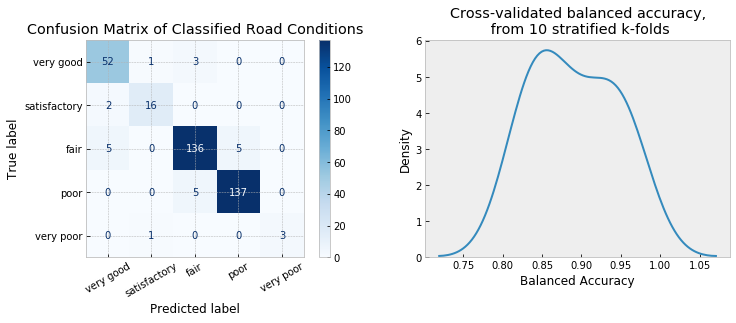

In [24]:
# ---- Printing scores
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred[0])*100:.2f}%")
print("Mean cross-validated balanced accuracy: ",
      f"{100*cv_accuracies[0].mean().round(2)}%, SD: {round(100*cv_accuracies[0].std(),3)}%\n")

y_labs = le.inverse_transform(df_merged['road_status'].unique())
print(classification_report(y_test, y_pred[0], target_names=y_labs, digits=2))

print(f"Cohen's Kappa: {cohen_kappa_score(y_test,y_pred[0]):.3f}\n")


# ---- Plotting
fig, axs=plt.subplots(1,2,figsize=(12,4))
plot_confusion_matrix(xgb_orig, x_test, y_test, cmap='Blues', display_labels=y_labs, ax=axs[0], xticks_rotation=30)
axs[0].set_title("Confusion Matrix of Classified Road Conditions"), plt.grid(False)

sns.kdeplot(cv_accuracies[0], ax=axs[1]), axs[1].set_ylabel('Density', fontsize=12), axs[1].set_xlabel('Balanced Accuracy')
axs[1].set_title("Cross-validated balanced accuracy,\n from 10 stratified k-folds")
plt.show()

Plotting the importance of the features, according to the model.

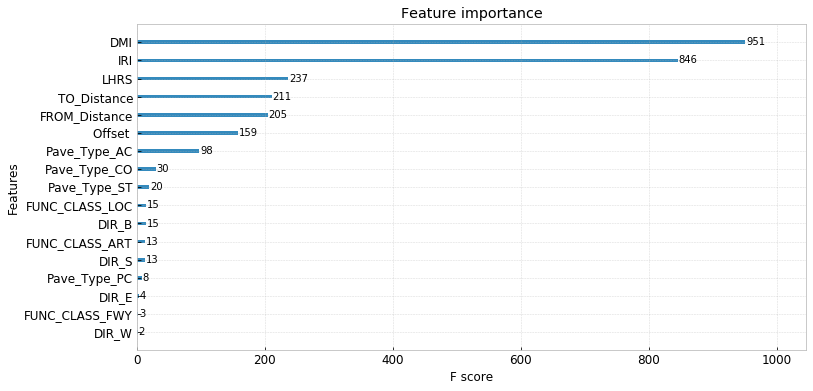

In [33]:
fig, ax= plt.subplots(figsize=(12,6))
xgboost.plot_importance(xgb_orig, ax=ax), ax.grid(alpha=.5), ax.set_facecolor('white')
ax.tick_params(axis='both', labelsize=12)
plt.show()

We can see that the Average Distress Manifestation Index (DMI) and Average International Roughness Index (IRI) of the road were the best predictors of whether a road was in very poor, poor, fair, satisfactory, or very good condition in Ontario. This doesn't seem that surprising, actually, given that both make up the PCI score.

| Feature   | Description |
| :----------- | :----------- |
| DMI      |  Average Distress Manifestation Index (DMI) of the pavement surface       |
| IRI      |  Average International Roughness Index (IRI; m/km) of the pavement surface |
| LHRS      |  Location reference based on Linear Highway Reference System Number |
| To_Distance      |  End chainage in kilometre (km) of the reporting interval |
| From_Distance      |  Start chainage in kilometre (km) of the reporting interval |
| Offset      |  Average International Roughness Index (IRI; m/km) of the pavement surface |
| Pave_Type      |  <dl><dt>One of the four pavement material types: </dt><dd>AC – Asphalt Concrete</dd><dd>PC – Portland Cement Concrete</dd><dd>COM – AC/PC Composite</dd><dd>ST – Surface-treated</dd></dl>|
| DIR     |  <dl><dt>Direction; travelling direction in which the pavement condition data was collected. <br />Surveys are conducted in one direction only for undivided highways.	Options: </dt><dd>E – East</dd><dd>W – West</dd><dd>N – North</dd><dd>S - South</dd></dl>|
| FUNC_CLASS      | <dl><dt>Function Class; one of the four function classes of the roadway: </dt><dd>FWY – Freeway</dd><dd>ART – Arterial Highway</dd><dd>COL – Collector</dd><dd>LOC – Local Road	Text</dd></dl>|

Path that one of the decision trees in the model took:

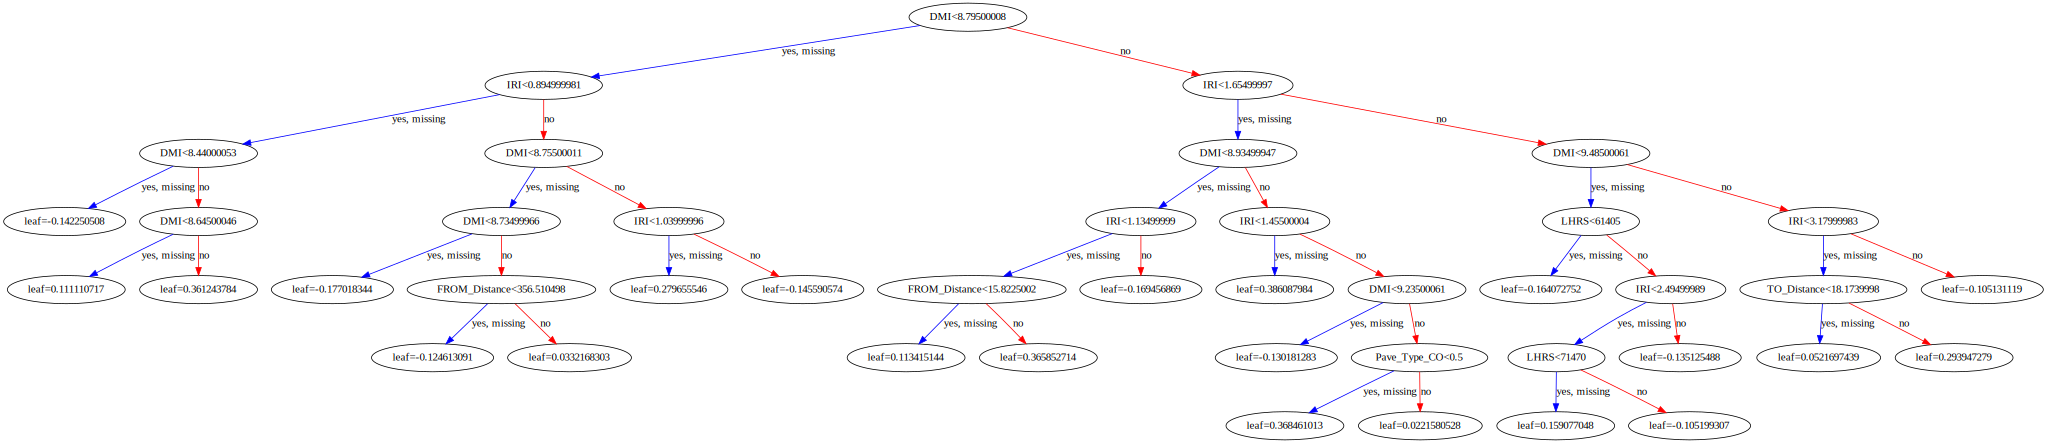

In [34]:
xgboost.to_graphviz(xgb_orig, num_trees=8, format='png')

### XGBoost Parameter Tuning and Testing
Could our model have been improved by changing its parameters somehow? Let's test this with a list of various parameter alternatives we could have chosen. We will also use stratified k-folds sampling while running our cross-validated search to make sure that we are accounting for the imbalanced frequency of outcome classes in our dataset.

In [35]:
param_grid = {
    'eta': [0.1, 0.3, 0.5],
    'max_depth':[4, 5, 6],
    'min_child_weight': [1, 1.3, 1.6],
    'alpha':[0,1,2],
    'n_estimators':[500, 750, 1000]}

scorers = {'neg_log_loss_score': 'neg_log_loss', 'balanced_accuracy': make_scorer(balanced_accuracy_score)}
iter_num = 80

model = XGBClassifier(objective='multi:softmax')
skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = seed)

Below are two search methods that we could use to find the ideal parameters. **Warning: `GridSearchCV` is VERY slow!**.

In [36]:
# Try grid search--warning: SLOW!.
# gsearch = GridSearchCV(model, param_grid=param_grid, scoring=scorers, n_jobs=2,
#                       cv=skf.split(x_train,y_train), verbose=3, 
#                                    refit='neg_log_loss_score', return_train_score=True)
#print(gsearch.fit(x, y))

In [37]:
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=iter_num, scoring=scorers, 
                                   n_jobs=2, cv=skf.split(x_train,y_train), verbose=False, random_state=seed,
                                   refit='neg_log_loss_score', return_train_score=True)
_ = random_search.fit(x_train, y_train)

print("\nThe best iteration of the model: \n\n", random_search.best_estimator_)
print("\n\nThe best parameter settings for the model: \n\n",random_search.best_params_)

[16:13:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

The best iteration of the model: 

 XGBClassifier(alpha=2, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.3, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1.3, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=2,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


The

### Optimizing XGBoost and Re-running the Model on the Ontario Road Pavement Dataset
Now that we have some optimized parameters, let's try re-running our first XGBoost model but with these new parameters put in place.

In [38]:
params_improved = {**params, **random_search.best_params_}

eval_set = [(x_train, y_train), (x_test, y_test)]

xgb_improved = XGBClassifier(**params_improved, use_label_encoder=False)
xgb_improved.fit(x_train, y_train, early_stopping_rounds=stop_after, eval_set=eval_set, eval_metric=["merror", "mlogloss"], verbose=False)

XGBClassifier(alpha=2, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.3,
              eval_metric=['mlogloss', 'merror'], gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1.3, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=8, num_class=5, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=2,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False, ...)

Let's extract the model's evaluation results.

In [39]:
train_results, test_results = xgb_improved.evals_result_['validation_0'], xgb_improved.evals_result_['validation_1']

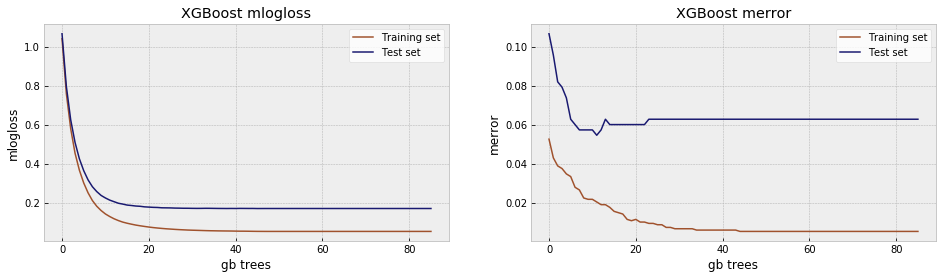

In [40]:
plot_eval_metrics=['mlogloss', 'merror']

fig, axs = plt.subplots(1,2, figsize=(16,4))
for m in enumerate(plot_eval_metrics):
    axs[m[0]].plot(range(0,len(train_results[m[1]])), train_results[m[1]], color='sienna', label='Training set', linewidth=1.5)
    axs[m[0]].plot(range(0,len(test_results[m[1]])), test_results[m[1]], color='midnightblue',label='Test set', linewidth=1.5)

    axs[m[0]].set_title(f'XGBoost {m[1]}'), 
    axs[m[0]].set_xlabel('gb trees'), axs[m[0]].set_ylabel(m[1])
    axs[m[0]].legend(facecolor='white')
plt.show()

In [41]:
y_pred[1] = xgb_improved.predict(x_test) # predict on test dataset.

skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = seed) # Do stratified
cv_accuracies[1] = cross_val_score(xgb_improved, X=x_train, y=y_train, 
                                cv=skf.split(x_train,y_train), scoring='balanced_accuracy', n_jobs=-1)

Balanced accuracy: 89.14%
Mean cross-validated balanced accuracy:  88.0%, SD: 5.956%

              precision    recall  f1-score   support

   very good       0.87      0.93      0.90        56
satisfactory       0.89      0.89      0.89        18
        fair       0.94      0.92      0.93       146
        poor       0.96      0.96      0.96       142
   very poor       1.00      0.75      0.86         4

    accuracy                           0.94       366
   macro avg       0.93      0.89      0.91       366
weighted avg       0.94      0.94      0.94       366

Cohen's Kappa: 0.906



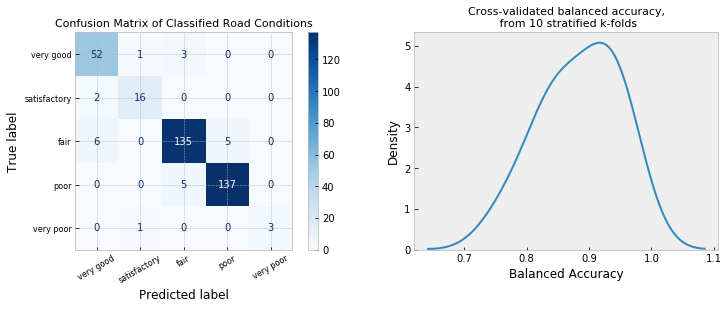

In [42]:
# ---- Printing scores
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred[1])*100:.2f}%")
print("Mean cross-validated balanced accuracy: ",
      f"{100*cv_accuracies[1].mean().round(2)}%, SD: {round(100*cv_accuracies[1].std(),3)}%\n")

y_labs = le.inverse_transform(df_merged['road_status'].unique())
print(classification_report(y_test, y_pred[1], target_names=y_labs, digits=2))

print(f"Cohen's Kappa: {cohen_kappa_score(y_test,y_pred[1]):.3f}\n")


# ---- Plotting
fig, axs=plt.subplots(1,2,figsize=(12,4))
plot_confusion_matrix(xgb_improved, x_test, y_test, cmap='Blues', display_labels=y_labs, ax=axs[0], xticks_rotation=30)
axs[0].tick_params(axis='both', which='major', labelsize=8)
axs[0].set_title("Confusion Matrix of Classified Road Conditions", fontsize=11), plt.grid(False)

sns.kdeplot(cv_accuracies[1], ax=axs[1]), axs[1].set_ylabel('Density', fontsize=12), axs[1].set_xlabel('Balanced Accuracy')
axs[1].set_title("Cross-validated balanced accuracy,\n from 10 stratified k-folds", fontsize=11)
plt.show()

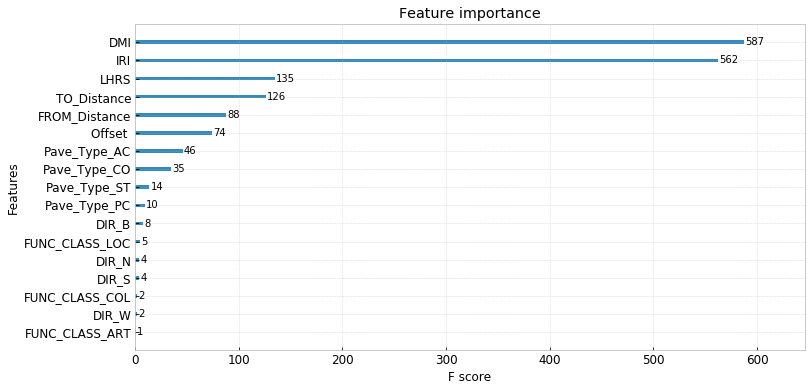

In [45]:
fig, ax= plt.subplots(figsize=(12,6))
xgboost.plot_importance(xgb_improved, ax=ax, importance_type ='weight'), ax.grid(alpha=.5), ax.set_facecolor('white')
ax.tick_params(axis='both', labelsize=12)
plt.show()

How do these results compare to the old model?

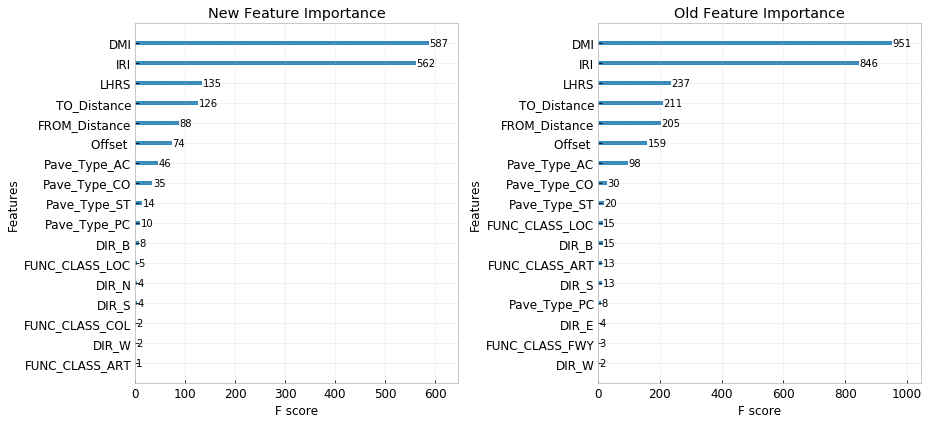

In [48]:
fig, ax= plt.subplots(1,2, figsize=(13,6))
xgboost.plot_importance(xgb_improved, ax=ax[0]), ax[0].grid(alpha=.5), ax[0].set_title('New Feature Importance')
ax[0].set_facecolor('white')
ax[0].tick_params(axis='both', labelsize=12)

# Note: I went back to set the original xgboost model to n=1000 estimators as well to ensure comparability
xgboost.plot_importance(xgb_orig, ax=ax[1]), ax[1].grid(alpha=.5), ax[1].set_title('Old Feature Importance')
ax[1].set_facecolor('white')
ax[1].tick_params(axis='both', labelsize=12)
fig.tight_layout()
plt.show()

Old balanced accuracy: 89.28%
Mean (old) cross-validated balanced accuracy:  89.0%, SD: 4.993%

              precision    recall  f1-score   support

   very good       0.88      0.93      0.90        56
satisfactory       0.89      0.89      0.89        18
        fair       0.94      0.93      0.94       146
        poor       0.96      0.96      0.96       142
   very poor       1.00      0.75      0.86         4

    accuracy                           0.94       366
   macro avg       0.94      0.89      0.91       366
weighted avg       0.94      0.94      0.94       366

Cohen's Kappa: 0.910


New balanced accuracy: 89.14%
Mean (new) cross-validated balanced accuracy:  88.0%, SD: 5.956%

              precision    recall  f1-score   support

   very good       0.87      0.93      0.90        56
satisfactory       0.89      0.89      0.89        18
        fair       0.94      0.92      0.93       146
        poor       0.96      0.96      0.96       142
   very poor       1.00  

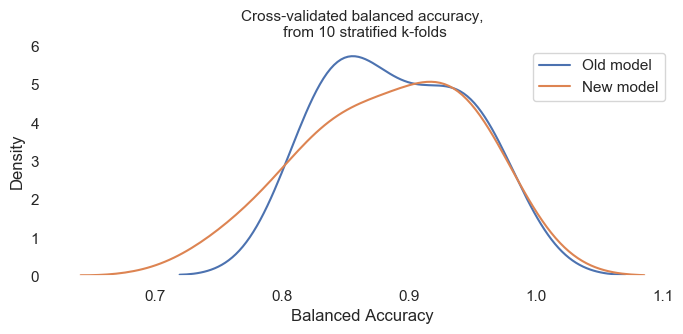

In [78]:
# Old model
print(f"Old balanced accuracy: {balanced_accuracy_score(y_test, y_pred[0])*100:.2f}%")
print("Mean (old) cross-validated balanced accuracy: ",
      f"{100*cv_accuracies[0].mean().round(2)}%, SD: {round(100*cv_accuracies[0].std(),3)}%\n")

print(classification_report(y_test, y_pred[0], target_names=y_labs, digits=2))
print(f"Cohen's Kappa: {cohen_kappa_score(y_test,y_pred[0]):.3f}\n")

# New model
print(f"\nNew balanced accuracy: {balanced_accuracy_score(y_test, y_pred[1])*100:.2f}%")
print("Mean (new) cross-validated balanced accuracy: ",
      f"{100*cv_accuracies[1].mean().round(2)}%, SD: {round(100*cv_accuracies[1].std(),3)}%\n")

print(classification_report(y_test, y_pred[1], target_names=y_labs, digits=2))
print(f"Cohen's Kappa: {cohen_kappa_score(y_test,y_pred[1]):.3f}\n")


# ------ plotting
fig, axs=plt.subplots(1,1,figsize=(8,3))
sns.set(rc={'axes.facecolor':'white'})
sns.kdeplot(cv_accuracies[0], ax=axs, label='Old model')
sns.kdeplot(cv_accuracies[1], ax=axs, label='New model')

plt.ylabel('Density', fontsize=12), plt.xlabel('Balanced Accuracy')
plt.title("Cross-validated balanced accuracy,\n from 10 stratified k-folds", fontsize=11)

plt.show()

### Suggestions on the Most Important Predictors of Road Pavement Quality
Let's now see if we could reduce our model into a more simplified version and see which features might be the most important predictors of road pavement quality.

In [67]:
thresholds = np.sort(xgb_improved.feature_importances_) # sorted from least to most important.
select_accuracy = [np.nan]*len(thresholds)

for i, thresh in zip(range(len(thresholds)), thresholds):
    # select features using threshold
    selection = SelectFromModel(xgb_improved, threshold=thresh, prefit=True)
    select_x_train = selection.transform(x_train)
    
    # Returns boolean mask/array of the features (as names) that were removed out from the training set by SelectFromModel,
    # based on our threshold--recall that thresh passing over the features in order of least to greatest importance.
    feature_idx = selection.get_support() 
    # Find/select the colnames from the training set that were NOT removed according to thresh
    feature_name = x_train.columns[feature_idx] 
    
    # Keep track of the features excluded from the training set
    reduced_x_train = pd.DataFrame(select_x_train, columns=feature_name)
    # Update eval set to allow for early stopping rounds to work
    select_eval_set = [(reduced_x_train, y_train), (x_test[x_test.columns & reduced_x_train.columns], y_test)]
    selection_model = XGBClassifier(**params_improved, use_label_encoder=False)
    selection_model.fit(reduced_x_train, y_train, early_stopping_rounds=stop_after, eval_set=select_eval_set, verbose=False)
    
    # Evaluate model
    select_x_test = selection.transform(x_test)
    select_pred = selection_model.predict(select_x_test)
    select_accuracy[i] = balanced_accuracy_score(y_test, select_pred)
    print(f"Threshold: {thresh:.3f}, balanced accuracy: {select_accuracy[i]*100.0:.2f}%, Features left: {select_x_train.shape[1]}")

Threshold: 0.000, balanced accuracy: 89.77%, Features left: 19
Threshold: 0.000, balanced accuracy: 89.77%, Features left: 19
Threshold: 0.000, balanced accuracy: 89.77%, Features left: 17
Threshold: 0.001, balanced accuracy: 89.77%, Features left: 16
Threshold: 0.002, balanced accuracy: 89.77%, Features left: 15
Threshold: 0.002, balanced accuracy: 89.77%, Features left: 14
Threshold: 0.008, balanced accuracy: 89.77%, Features left: 13
Threshold: 0.008, balanced accuracy: 89.77%, Features left: 12
Threshold: 0.010, balanced accuracy: 89.77%, Features left: 11
Threshold: 0.010, balanced accuracy: 89.77%, Features left: 10
Threshold: 0.013, balanced accuracy: 89.77%, Features left: 9
Threshold: 0.014, balanced accuracy: 89.91%, Features left: 8
Threshold: 0.018, balanced accuracy: 89.91%, Features left: 7
Threshold: 0.018, balanced accuracy: 88.66%, Features left: 6
Threshold: 0.021, balanced accuracy: 88.66%, Features left: 5
Threshold: 0.031, balanced accuracy: 88.80%, Features left: 

Let's the extract feature names used during our testing process and sort them in ascending order of their feature importance. We'll use this to plot the changes in the balanced accuracy of our model from the progressive removal of features (in order of least to greatest importance).

In [68]:
feature_dict = {}
for col, imp in zip(x_train.columns,xgb_improved.feature_importances_):
    feature_dict.update({col: imp})
feature_imp_named = pd.DataFrame(data=feature_dict, index=[0]).sort_values(by=0, axis=1)
feature_imp_named

,DIR_E,FUNC_CLASS_FWY,FUNC_CLASS_ART,DIR_B,DIR_N,FUNC_CLASS_COL,FROM_Distance,Offset,Pave_Type_ST,FUNC_CLASS_LOC,LHRS,DIR_S,TO_Distance,Pave_Type_PC,Pave_Type_AC,Pave_Type_CO,DIR_W,IRI,DMI
0,0.0,0.0,0.000061,0.001371,0.001523,0.002328,0.007663,0.008348,0.009651,0.009776,0.012997,0.013738,0.017868,0.018492,0.0211,0.030854,0.035115,0.197246,0.611869


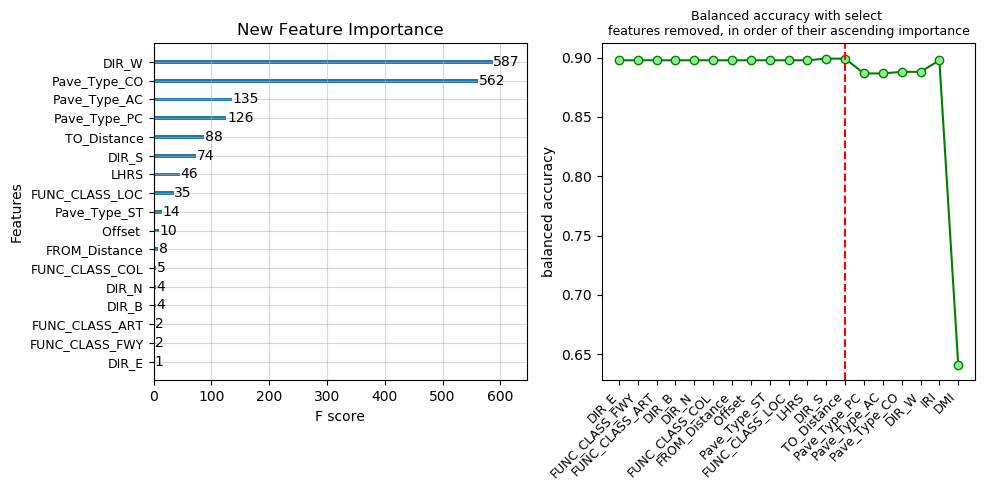

In [69]:
plt.style.use('default')
fig, ax= plt.subplots(1,2, figsize=(10,5))
xgboost.plot_importance(xgb_improved, ax=ax[0]), ax[0].grid(alpha=.5), ax[0].set_title('New Feature Importance')
ax[0].set_yticklabels(labels=feature_imp_named.columns, fontsize=9)

ax[1].plot(range(len(thresholds)), select_accuracy, marker='o', markerfacecolor='lightgreen', color='green')
ax[1].set_xticks(range(len(thresholds)))
ax[1].set_xticklabels(feature_imp_named.columns, rotation=45, ha='right', fontsize=9), 

ax[1].set_ylabel('balanced accuracy')
ax[1].set_title('Balanced accuracy with select \nfeatures removed, in order of their ascending importance', fontsize=9)
ax[1].axvline(x=12, ymin=0, ymax=1, color='red', ls='--')

fig.tight_layout()
plt.show()

### Conclusions:
The results of the feature importance plot, as well as from the balanced accuracy plot, suggest that `DMI` and `IRI` may be the two most important features which predict for road pavement quality in Ontario. Factoring in the 'to' (and possibly, from) distances of a road may also result in slightly more accurate predictions of said road's pavement quality.

**Note:** `DMI` and `IRI` were both likely strongly associated with our outcome *because* they are already constructs of our outcome--PCI--as mentioned in the introduction. Thus, our modeling was likely done on data that was already somewhat redundant. Our modeling and results could have been more meaningful--and less redundant--by *not* using features that are already constructs of our outcome. 